In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/DLW Hackathon'

In [ ]:
import pandas as pd
import numpy as np
import re

# Reading Data

In [ ]:
df = pd.read_csv('urlset.csv', encoding='iso-8859-1', on_bad_lines='skip')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0.0    48009
1.0    47904
Name: label, dtype: int64


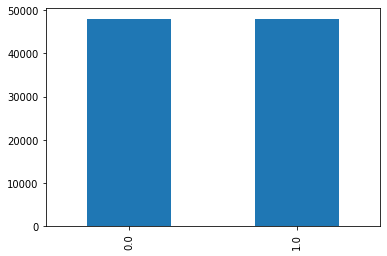

In [ ]:
new_df = df[["domain","label"]]
new_df = new_df.dropna()
print(new_df['label'].value_counts())
new_df['label'].value_counts().plot(kind='bar')

In [ ]:
new_df.head()

,domain,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0
3,mail.printakid.com/www.online.americanexpress....,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0


# Extracting Features from Phishing URLs

In [ ]:
#Using IP Addresses within Address Bar
def isIPAddress(url):
    # declaring the regex pattern for IP addresses
    pattern = re.compile(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})')
    if (pattern.search(url)):
        return 1
    return 0

#Long URL (Characters)
def urlLength(url):
    return len(url)

#URL with @ Symbol
def hasAt(url):
    if '@' in url:
        return 1
    return 0

#URL with multiple "//" for redirecting
def hasDoubleSlash(url):
    if '//' in url:
        return 1
    return 0

#URL Domain with - Symbol
def hasDash(url):
    if '-' in url.split('.')[0]:
        return 1
    return 0

#URL with multiple "." for subdomains
def hasMultipleDots(url):
    if '.' in url:
        return 1
    return 0

#URL with "?"
def hasQuestion(url):
    if '?' in url:
        return 1
    return 0

#URL with "cmd"
def hasCmd(url):
    if 'cmd' in url:
        return 1
    return 0

#URL with ".php"
def hasPhp(url):
    if '.php' in url:
        return 1
    return 0

#URL with HTTPS in domain
def hasHTTPorHTTPS(url):
    if 'http' in url:
        return 1
    return 0

#Total Digits Domain
def digitsDomain(url):
    return len(re.sub("[^0-9]", "", url.split("/", 1)[0]))

#Total Digits Path
def digitsPath(url):
    if len(url.split("/", 1)) == 2:
        return len(re.sub("[^0-9]", "", url.split("/", 1)[1]))
    return 0

In [ ]:
#!pip install tldextract

In [ ]:
import nltk
nltk.download('punkt')
import tldextract
from urllib.parse import urlparse
from nltk.util import ngrams
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix

def generate_url_ngrams(n: int, url: str):
    url_formated = ''
    
    for index, char in enumerate(url):
        if index % n == 0:
            url_formated += ' '
        url_formated += char

    ngram = ngrams(sequence=nltk.word_tokenize(url_formated), n=n)
    
    ngram_url = {}
    for grams in ngram:
        for gx in grams:
            ngram_url[gx] = 1
    return ngram_url


def get_fields_url(url: str):
    try:
        features = dict()

        url_tldextract = tldextract.extract(url) 
        url_urlparse = urlparse(f"http://{url}")
        url_info = [
            {"name": "domain", "string": url_tldextract.domain},
            {"name": "subdomain", "string": url_tldextract.subdomain},
            {"name": "suffix", "string": url_tldextract.suffix},
            {"name": "path", "string": url_urlparse.path},
            {"name": "params", "string": url_urlparse.params},
            {"name": "query", "string": url_urlparse.query},
            {"name": "fragment", "string": url_urlparse.fragment}
        ]
        features.update(generate_url_ngrams(2, url_tldextract.domain))
        
        for each_url in url_info:
            features[f'len_{each_url["name"]}'] = len(each_url["string"])
            for char_ in list(map(str, "-@_?=&./,")):
                features[f'char{char_}-{each_url["name"]}'] = each_url["string"].count(char_)

            if "domain" == each_url["name"] or "path" == each_url["name"]:
                total_letter, total_number = 0, 0
                for char_ in list(map(str, "abcdefghijklmnopqrstuvwxyz")):
                    total_letter += each_url["string"].lower().count(char_)

                for char_ in list(map(str, "0123456789")):
                    total_number += each_url["string"].lower().count(char_)

                features[f'letter_len_{each_url["name"]}'] = total_letter
                features[f'number_len_{each_url["name"]}'] = total_number
    except Exception as e:
        return e      
    return features   

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
output = []
features = []

progress = 0
progress_percentage = 0
total_progress = len(new_df["domain"])
for url, target in zip(new_df["domain"], new_df["label"]):
    features_json = get_fields_url(url)
    features_json['ip_addr'] = isIPAddress(url)
    features_json['url_len'] = urlLength(url)
    features_json['has_at'] = hasAt(url)
    features_json['has_double_slash'] = hasDoubleSlash(url)
    features_json['has_dash'] = hasDash(url)
    features_json['has_multiple_dots'] = hasMultipleDots(url)
    features_json['has_question_mark'] = hasQuestion(url)
    features_json['has_cmd'] = hasCmd(url)
    features_json['has_php'] = hasPhp(url)
    features_json['has_http'] = hasHTTPorHTTPS(url)
    features_json['digits_domain'] = digitsDomain(url)
    features_json['digits_path'] = digitsPath(url)

    if features_json:
        if target == 1:
            target_int = 1
        if target == 0:
            target_int = 0
            
        output.append(target_int)
        features.append(features_json)

    progress += 1
    if progress % (total_progress/10) == 0:
        print(progress_percentage)
        progress_percentage += 10

In [ ]:
pre_processor = DictVectorizer(sparse=True)
X = pre_processor.fit_transform(features)
X = csr_matrix(X)
X = X.tocsr()

y = np.array(output).astype(int)

In [ ]:
#Build preprocessor
pre_processor = DictVectorizer(sparse=True)
pre_processor.fit_transform(features)

<95913x1411 sparse matrix of type '<class 'numpy.float64'>'
	with 8690244 stored elements in Compressed Sparse Row format>

# Training Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, train_size=0.7)

In [ ]:
#XGBoost
xgb = XGBClassifier(learning_rate=0.3, n_estimators=100,
                             objective='binary:logistic', seed=1,
                             silent=True, n_jobs=-1, max_depth=8,
                             colsample_bytree=1.0,
                             subsample=1.0)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
print('XGBoost:', accuracy_score(y_test, pred_xgb))

XGBoost: 0.9442899840133454


In [ ]:
#Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_rf = rfc.predict(X_test)
print('Random Forest:', accuracy_score(y_test,pred_rf))

Random Forest: 0.9494335163689441


In [ ]:
#Logistic Regression
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train, y_train)
pred_log = lg.predict(X_test)
print('Logistic Regression:', accuracy_score(y_test, pred_log))

Logistic Regression: 0.8938625147702787


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
#FF Neural Network (For more information refer to section below)
trainX = X_train.toarray()
testX = X_test.toarray()
trainY = np.array(y_train)
testY = np.array(y_test)

nn = Sequential()
nn.add(Input(shape=(trainX.shape[1], ), name='Input-Layer'))
nn.add(Dense(28, activation='relu', name='Hidden-Layer'))
nn.add(Dense(1, activation='sigmoid', name='Output-Layer'))
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy', 'Precision', 'Recall'])
nn.fit(trainX, trainY, batch_size = 20, epochs = 50, verbose=0)

pred_nn = nn.predict(testX)
print(nn.evaluate(testX, testY, batch_size = 1, verbose=2))
print('Neural Network:', accuracy_score(y_test, pred_log))

28774/28774 - 31s - loss: 0.2152 - Accuracy: 0.9328 - precision: 0.9240 - recall: 0.9435 - 31s/epoch - 1ms/step
[0.2152305245399475, 0.9328212738037109, 0.9240334033966064, 0.9434577226638794]
Neural Network: 0.8544866893723501


## Save Models

In [ ]:
import joblib

joblib.dump(model, "Models/XGBoost")
joblib.dump(rfc, "Models/RandomForest")
joblib.dump(lg, "Models/LogisticRegression")
nn.save("Models/NeuralNet.h5")
joblib.dump(pre_processor, "Models/Preprocessor")

['Models/Preprocessor']

## Neural Networks (Exploration)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense

def train_test_nn(X, y, hidden_units, batch_size=10, epoch=10) :
    trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=0)
    trainX = trainX.toarray()
    testX = testX.toarray()
    trainY = np.array(trainY)
    testY = np.array(testY)
    model = Sequential()
    model.add(Input(shape=(trainX.shape[1], ), name='Input-Layer'))
    model.add(Dense(hidden_units, activation='relu', name='Hidden-Layer'))
    model.add(Dense(1, activation='sigmoid', name='Output-Layer'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy', 'Precision', 'Recall'])
    model.fit(trainX, trainY, batch_size = batch_size, epochs = epoch, verbose=0)
    score = model.evaluate(testX, testY, batch_size = 1, verbose=2)
    return score



Explore Hidden Units and Batch Sizes

In [ ]:
hidden_units = [12, 16, 20, 24]
batch_sizes = [10, 20, 30, 40]

In [ ]:
accuracies_nn = []
precisions_nn = []
recalls_nn = []
for bs in batch_sizes :
    a = []
    p = []
    r = []
    for hn in hidden_units :
        s = train_test_nn(X, y, hn, batch_size=bs)
        a.append(s[1])
        p.append(s[2])
        r.append(s[3])
    accuracies_nn.append(a)
    precisions_nn.append(p)
    recalls_nn.append(r)

28774/28774 - 34s - loss: 0.1875 - Accuracy: 0.9282 - precision: 0.9393 - recall: 0.9153 - 34s/epoch - 1ms/step
28774/28774 - 55s - loss: 0.1683 - Accuracy: 0.9347 - precision: 0.9597 - recall: 0.9074 - 55s/epoch - 2ms/step
28774/28774 - 32s - loss: 0.1681 - Accuracy: 0.9341 - precision: 0.9569 - recall: 0.9091 - 32s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1684 - Accuracy: 0.9356 - precision: 0.9688 - recall: 0.9001 - 32s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.2016 - Accuracy: 0.9204 - precision: 0.9432 - recall: 0.8944 - 32s/epoch - 1ms/step
28774/28774 - 31s - loss: 0.1738 - Accuracy: 0.9344 - precision: 0.9515 - recall: 0.9152 - 31s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1787 - Accuracy: 0.9327 - precision: 0.9609 - recall: 0.9019 - 32s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1659 - Accuracy: 0.9413 - precision: 0.9478 - recall: 0.9340 - 32s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1854 - Accuracy: 0.9292 - precision: 0.9384 - recall: 0.9185 - 32s/epoch - 1

In [ ]:
accuracies_nn_df = pd.DataFrame(accuracies_nn, columns=hidden_units, index=batch_sizes)
accuracies_nn_df

,12,16,20,24
10,0.928164,0.934698,0.934107,0.935602
20,0.920380,0.934350,0.932682,0.941336
30,0.929207,0.929554,0.937617,0.936019
40,0.928442,0.929450,0.934420,0.934941


In [ ]:
precisions_nn_df = pd.DataFrame(precisions_nn, columns=hidden_units, index=batch_sizes)
precisions_nn_df

,12,16,20,24
10,0.939303,0.959670,0.956859,0.968769
20,0.943205,0.951527,0.960928,0.947814
30,0.938433,0.948026,0.952049,0.934888
40,0.914769,0.938963,0.928297,0.927316


In [ ]:
recalls_nn_df = pd.DataFrame(recalls_nn, columns=hidden_units, index=batch_sizes)
recalls_nn_df

,12,16,20,24
10,0.915316,0.907383,0.909053,0.900077
20,0.894440,0.915176,0.901886,0.933964
30,0.918516,0.908775,0.921509,0.937165
40,0.944750,0.918447,0.941410,0.943706


Explore Hidden Units

In [ ]:
hidden_units = [20, 24, 28, 32]

accuracies_nn = []
precisions_nn = []
recalls_nn = []

a = []
p = []
r = []
for hn in hidden_units :
    s = train_test_nn(X, y, hn, batch_size=20)
    a.append(s[1])
    p.append(s[2])
    r.append(s[3])
accuracies_nn.append(a)
precisions_nn.append(p)
recalls_nn.append(r)

28774/28774 - 32s - loss: 0.1888 - Accuracy: 0.9296 - precision: 0.9152 - recall: 0.9468 - 32s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1837 - Accuracy: 0.9353 - precision: 0.9291 - recall: 0.9425 - 32s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1702 - Accuracy: 0.9396 - precision: 0.9669 - recall: 0.9102 - 32s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1772 - Accuracy: 0.9367 - precision: 0.9270 - recall: 0.9478 - 32s/epoch - 1ms/step


Explore Epochs

In [ ]:
epochs = [10, 20, 30]

accuracies_nn = []
precisions_nn = []
recalls_nn = []

a = []
p = []
r = []
for ep in epochs :
    s = train_test_nn(X, y, 28, batch_size=20, epoch=ep)
    a.append(s[1])
    p.append(s[2])
    r.append(s[3])
accuracies_nn.append(a)
precisions_nn.append(p)
recalls_nn.append(r)

28774/28774 - 40s - loss: 0.1958 - Accuracy: 0.9211 - precision: 0.9756 - recall: 0.8636 - 40s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1687 - Accuracy: 0.9390 - precision: 0.9411 - recall: 0.9365 - 32s/epoch - 1ms/step
28774/28774 - 32s - loss: 0.1791 - Accuracy: 0.9405 - precision: 0.9461 - recall: 0.9340 - 32s/epoch - 1ms/step


# Results

In [ ]:
final_pred = []
for i in range(len(pred_log)):
    if pred_nn[i] == 1:
        nn_pred = 1
    else:
        nn_pred = 0
    if pred_xgb[i]+pred_nn[i]+pred_rf[i]+pred_log[i]+nn_pred > 2:
        final_pred.append(1)
    else:
        final_pred.append(0)

In [ ]:
print(accuracy_score(final_pred,y_test))

0.9469660109821366


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
classification_repo = classification_report(final_pred,y_test)
confusion_mat = confusion_matrix(final_pred,y_test)
false_neg = confusion_mat[1][0]
false_pos = confusion_mat[0][1]
print("False Negative:", false_neg)
print("False Positive:", false_pos)
print(confusion_mat,"\n",classification_repo)

False Negative: 578
False Positive: 948
[[13782   948]
 [  578 13466]] 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     14730
           1       0.93      0.96      0.95     14044

    accuracy                           0.95     28774
   macro avg       0.95      0.95      0.95     28774
weighted avg       0.95      0.95      0.95     28774



# Application (Loading Models to Test on Individual URLs)

Load Models

In [ ]:
from keras.models import load_model
import joblib

rf_imported = joblib.load("Models/RandomForest")
lg_imported = joblib.load("Models/LogisticRegression")
xgb_imported = joblib.load("Models/XGBoost")
nn_imported = load_model("Models/NeuralNet.h5")
pre_processor_imported = joblib.load("Models/Preprocessor")

In [ ]:
len(pre_processor_imported.feature_names_)

1411

In [ ]:
def get_features(url):
    if "http://" == url[:7]:
        url = url[7:]
    elif "https://" == url[:8]:
        url = url[8:]
    features_json = {}
    features_json = get_fields_url(url)
    features_json['ip_addr'] = isIPAddress(url)
    features_json['url_len'] = urlLength(url)
    features_json['has_at'] = hasAt(url)
    features_json['has_double_slash'] = hasDoubleSlash(url)
    features_json['has_dash'] = hasDash(url)
    features_json['has_multiple_dots'] = hasMultipleDots(url)
    features_json['has_question_mark'] = hasQuestion(url)
    features_json['has_cmd'] = hasCmd(url)
    features_json['has_php'] = hasPhp(url)
    features_json['has_http'] = hasHTTPorHTTPS(url)
    features_json['digits_domain'] = digitsDomain(url)
    features_json['digits_path'] = digitsPath(url)
    return features_json

def feature_to_vector(features_json, pre_processor):   
    X = pre_processor.transform([features_json])
    X = csr_matrix(X)
    X = X.tocsr()
    return X

def get_prediction(vector, lg, xgb, rfc, nn):
    #print(lg.predict(vector),xgb.predict(vector),rfc.predict(vector),nn.predict(vector))
    if nn.predict(vector) == 1:
        nn_pred = 1
    else:
        nn_pred = 0
    if lg.predict(vector)+xgb.predict(vector)+rfc.predict(vector)+nn_pred > 2:
        return 1
    return 0

def url_phishing_predictor(url, pre_processor, lg, xgb, rfc, nn):
    return get_prediction(feature_to_vector(get_features(url), pre_processor), lg, xgb, rfc, nn)

In [ ]:
testing_url_1 = 'nobell.it/70ffb52d079109dca5664cce6f317373782/'
testing_url_2 = 'www.google.com'
testing_url_3 = 'https://www.ntu.edu.sg/eee/student-life/mlda'
testing_url_4 = 'myuniversity.edurenewal.com'

print(url_phishing_predictor(testing_url_1, pre_processor_imported, lg_imported, xgb_imported, rf_imported, nn_imported))
print(url_phishing_predictor(testing_url_2, pre_processor_imported, lg_imported, xgb_imported, rf_imported, nn_imported))
print(url_phishing_predictor(testing_url_3, pre_processor_imported, lg_imported, xgb_imported, rf_imported, nn_imported))
print(url_phishing_predictor(testing_url_4, pre_processor_imported, lg_imported, xgb_imported, rf_imported, nn_imported))

1
0
0
1


# Version 1 - Archive

In [ ]:
Y = new_df["label"]
X = new_df.drop(["label","domain"],axis=1)

In [ ]:
new_df['ip_addr'] = new_df['domain'].map(isIPAddress)
new_df['url_len'] = new_df['domain'].map(urlLength)
new_df['has_at'] = new_df['domain'].map(hasAt)
new_df['has_double_slash'] = new_df['domain'].map(hasDoubleSlash)
new_df['has_dash'] = new_df['domain'].map(hasDash)
new_df['has_multiple_dots'] = new_df['domain'].map(hasMultipleDots)
new_df['has_question_mark'] = new_df['domain'].map(hasQuestion)
new_df['has_cmd'] = new_df['domain'].map(hasCmd)
new_df['has_php'] = new_df['domain'].map(hasPhp)
new_df['has_http'] = new_df['domain'].map(hasHTTPorHTTPS)
new_df['digits_domain'] = new_df['domain'].map(digitsDomain)
new_df['digits_path'] = new_df['domain'].map(digitsPath)

display(new_df.head())

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95913 entries, 0 to 96004
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   domain             95913 non-null  object 
 1   label              95913 non-null  float64
 2   ip_addr            95913 non-null  int64  
 3   url_len            95913 non-null  int64  
 4   has_at             95913 non-null  int64  
 5   has_double_slash   95913 non-null  int64  
 6   has_dash           95913 non-null  int64  
 7   has_multiple_dots  95913 non-null  int64  
 8   has_question_mark  95913 non-null  int64  
 9   has_cmd            95913 non-null  int64  
 10  has_php            95913 non-null  int64  
 11  has_http           95913 non-null  int64  
 12  digits_domain      95913 non-null  int64  
 13  digits_path        95913 non-null  int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 11.0+ MB


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
X_train,X_test,Y_train,Y_test 

(       ip_addr  url_len  has_at  has_double_slash  has_dash  \
 68227        0       27       0                 0         0   
 65206        0       36       0                 0         0   
 59689        0       23       0                 0         0   
 62056        0       26       0                 0         0   
 72235        0       28       0                 0         0   
 ...        ...      ...     ...               ...       ...   
 21335        0       50       0                 0         0   
 45983        0       21       0                 0         0   
 42705        0      124       0                 0         0   
 43659        0       52       0                 0         0   
 68360        0       27       0                 0         0   
 
        has_multiple_dots  has_question_mark  has_cmd  has_php  has_http  \
 68227                  1                  0        0        0         0   
 65206                  1                  0        0        0         0   
 5

In [ ]:
#Using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lg = LogisticRegression()
lg.fit(X_train,Y_train)
pred_log = lg.predict(X_test)
print(accuracy_score(pred_log,Y_test))

0.801907939321274


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
#Using SVM 
from sklearn import svm
sv = svm.SVC()
sv.fit(X_train,Y_train)
pred_svm = sv.predict(X_test)
print(accuracy_score(pred_svm,Y_test))

0.7777719856122609


In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
pred_rf = rfc.predict(X_test)
print(accuracy_score(pred_rf,Y_test))

0.8316738779127353


In [ ]:
#Using XGB 
from xgboost import XGBClassifier
xg = XGBClassifier(n_estimators=300)
xg.fit(X_train,Y_train)
pred_xg = xg.predict(X_test)
print(accuracy_score(pred_xg,Y_test))

0.8285982380232497


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
classification_repo = classification_report(pred_rf,Y_test)
confusion_mat = confusion_matrix(pred_rf,Y_test)
false_neg = confusion_mat[1][0]
false_pos = confusion_mat[0][1]
print("False Negative:", false_neg)
print("False Positive:", false_pos)
print(confusion_mat,"\n",classification_repo)

False Negative: 943
False Positive: 2286
[[8612 2286]
 [ 943 7342]] 
               precision    recall  f1-score   support

         0.0       0.90      0.79      0.84     10898
         1.0       0.76      0.89      0.82      8285

    accuracy                           0.83     19183
   macro avg       0.83      0.84      0.83     19183
weighted avg       0.84      0.83      0.83     19183

